# Business Problem :

## Food & Beverages Spend Prediction in Club Mahindra Resorts

Club Mahindra (Club M) makes significant revenue from Food and Beverages (F&B) sales in their resorts. The members of Club M are offered a wide variety of items in either buffet or À la carte form. Following are some benefits that the model to predict the spend by a member in their next visit to a resort will bring:                                            
1. Predicting the F&B spend of a member in a resort would help in improving the pre-sales during resort booking through web and mobile app                                                                             
2. Targeted campaigns to suit the member taste and preference of F&B                                                           
3. Providing members in the resort with a customized experience and offers                                           
4. Help resort kitchen to plan the inventory and food quantity to be prepared in advance                                         
Given the information related to resort, club member, reservation etc. the task is to predict average spend per room night on food and beverages for the each reservation in the test set

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [44]:
#Importing necessary Libraries
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor,StackingCVRegressor

In [18]:
# Columns of the Dataset
datadict=pd.read_excel('Data_Dictionary.xlsx')
datadict

,Variable,Description
0,reservation_id,Reservation ID
1,booking_date,Date of booking
2,checkin_date,Checkin date recorded at the time of booking
3,checkout_date,Checkout date recorded at the time of booking
4,channel_code,Different channels of booking
5,main_product_code,Type of product a member has purchased
6,numberofadults,Number of adults travelling
7,numberofchildren,Number of children travelling
8,persontravellingid,Type of person travelling
9,resort_region_code,Resort Region


# Reading Data

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [5]:
train.head(3)

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,...,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,05/04/18,05/04/18,06/04/18,3,1,2,0,46,3,...,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,23/01/15,11/04/15,16/04/15,1,1,2,0,46,3,...,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,28/01/15,01/02/15,05/02/15,1,1,2,0,47,1,...,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602


**Data Overview:**

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341424 entries, 0 to 341423
Data columns (total 24 columns):
reservation_id                        341424 non-null object
booking_date                          341424 non-null object
checkin_date                          341424 non-null object
checkout_date                         341424 non-null object
channel_code                          341424 non-null int64
main_product_code                     341424 non-null int64
numberofadults                        341424 non-null int64
numberofchildren                      341424 non-null int64
persontravellingid                    341424 non-null int64
resort_region_code                    341424 non-null int64
resort_type_code                      341424 non-null int64
room_type_booked_code                 341424 non-null int64
roomnights                            341424 non-null int64
season_holidayed_code                 341310 non-null float64
state_code_residence                  33666

In [7]:
# Checking for travellers who have previos bookings
res_id=pd.Series(train['memberid'].tolist())
booking_more_than_one=np.sum(res_id.value_counts()>1)
booking_more_than_one

77007

**Checking for Missing Values:**

In [8]:
train.isnull().sum()

reservation_id                           0
booking_date                             0
checkin_date                             0
checkout_date                            0
channel_code                             0
main_product_code                        0
numberofadults                           0
numberofchildren                         0
persontravellingid                       0
resort_region_code                       0
resort_type_code                         0
room_type_booked_code                    0
roomnights                               0
season_holidayed_code                  114
state_code_residence                  4764
state_code_resort                        0
total_pax                                0
member_age_buckets                       0
booking_type_code                        0
memberid                                 0
cluster_code                             0
reservationstatusid_code                 0
resort_id                                0
amount_spen

Replacing the missing values with mode of the respective columns

In [4]:
temp_season_holidayed_code=train[train['season_holidayed_code'].notna()]
temp_state_code_residence=train[train['state_code_residence'].notna()]
train['season_holidayed_code']=train['season_holidayed_code'].fillna(temp_season_holidayed_code['season_holidayed_code'].mode()[0])
train['state_code_residence']=train['state_code_residence'].fillna(temp_season_holidayed_code['state_code_residence'].mode()[0])
test['season_holidayed_code']=test['season_holidayed_code'].fillna(temp_season_holidayed_code['season_holidayed_code'].mode()[0])
test['state_code_residence']=test['state_code_residence'].fillna(temp_season_holidayed_code['state_code_residence'].mode()[0])


# EDA

The dependent variable of the experiment is 'amount_spent_per_room_night_scaled' .Let's take a look at the distribution of scaled variable

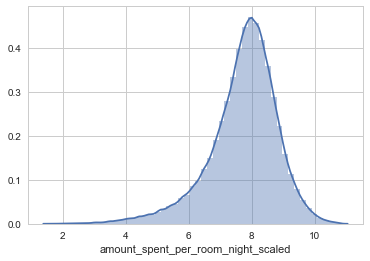

In [36]:
sns.distplot(train['amount_spent_per_room_night_scaled'])

In [136]:
print('Skewness :',train['amount_spent_per_room_night_scaled'].skew())
print('Kurtosis :',train['amount_spent_per_room_night_scaled'].kurt())

Skewness : -0.9232293889747991
Kurtosis : 1.814963523010979


The dependent variable is almost normally distributed with a negetive skewness of 0.92 and kurtosis of 1.814

**Boxplot between Resort Type and amount per room night scaled:**

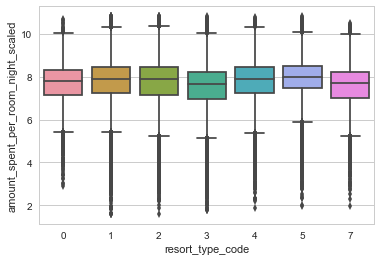

In [121]:
sns.set(style='whitegrid')
sns.boxplot(y='amount_spent_per_room_night_scaled',x='resort_type_code',data=train)

In Almost 75 % of cases across all Resort types the scaled valued of spending is more than 8.

**Boxplot between Channel Code and amount per room night scaled:**

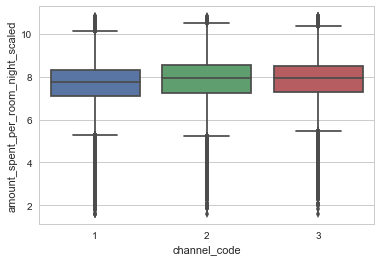

In [111]:

sns.boxplot(y='amount_spent_per_room_night_scaled',x='channel_code',data=train)

The boxplots between different types of business channel and the scaled value of spending is highly overlapped.

**Boxplot between Resort Type and amount per room night scaled:**

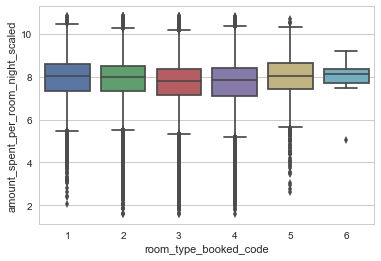

In [64]:

sns.boxplot(y='amount_spent_per_room_night_scaled',x='room_type_booked_code',data=train)

(1) For Room type 6 the maximum scaled spending is 9 , where for other type of rooms maximum is more than 10.              
(2) For all type of rooms the spending is more than 8 for more than 75% of cases,while it's less than 8 for 50% of cases.

**Correlation Matrix:**

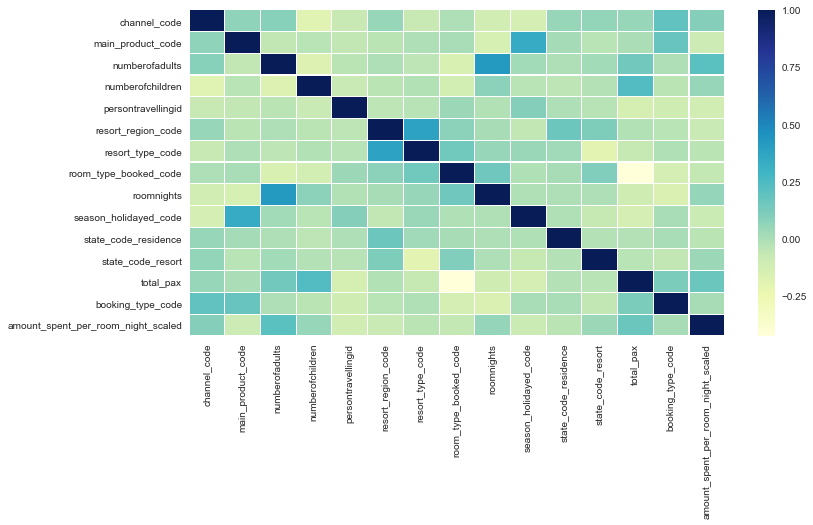

In [114]:
corrmat=train.corr(method='spearman')
f,ax=plt.subplots(figsize=(12,6))
sns.heatmap(corrmat,ax=ax,cmap="YlGnBu", linewidths=0.1)

The dependent variable is modarately correleted with : number of adults,total number of clients,channel code ,room nights.

Let's take a look at the scatter plot of two highly correleted features

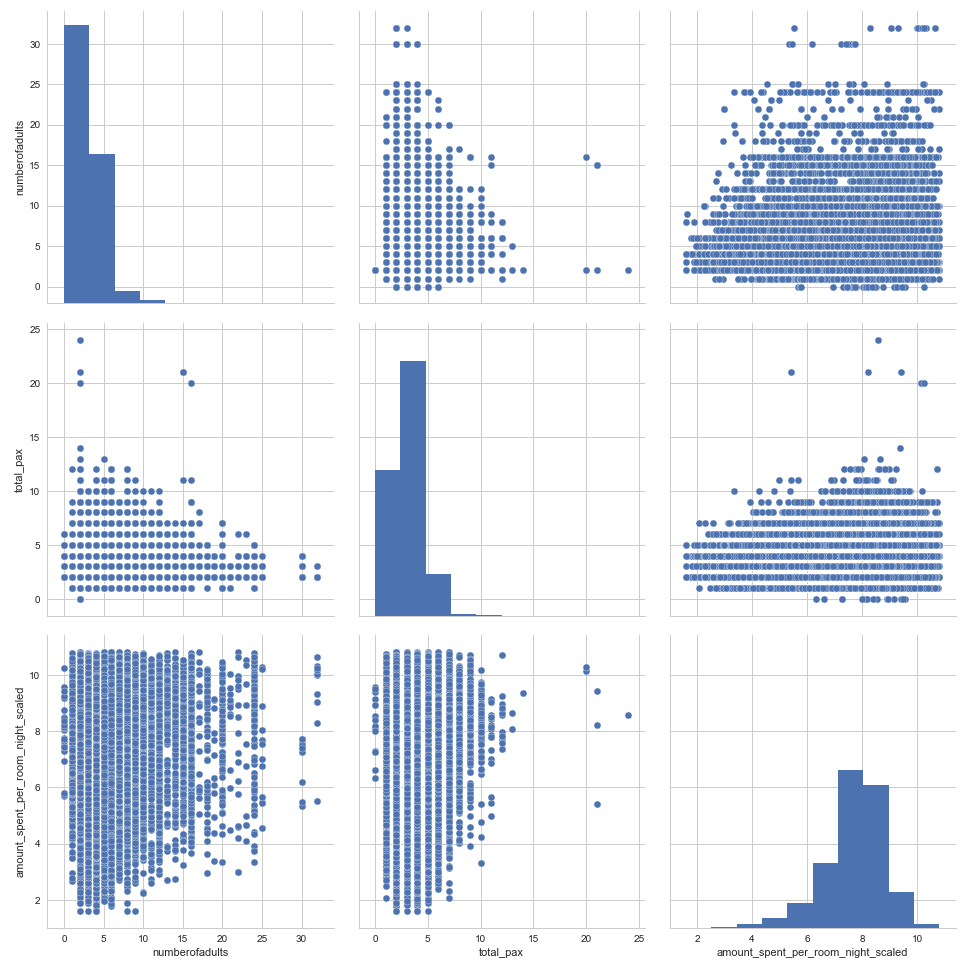

In [134]:
cols=['numberofadults','total_pax','amount_spent_per_room_night_scaled']
sns.pairplot(train[cols],size=4.5)

**Boxplot between Total Persons and amount per room night scaled:**

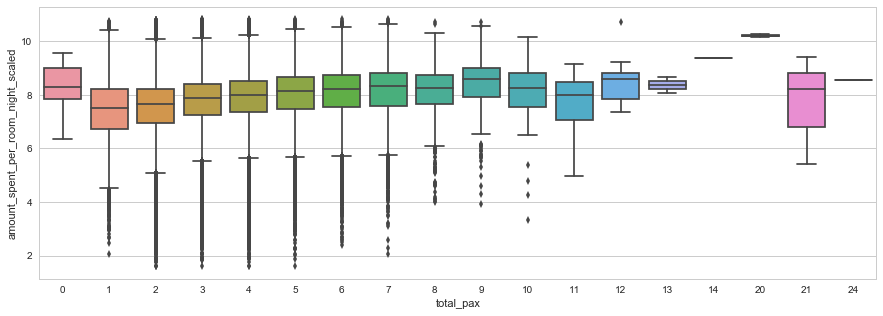

In [45]:
f,ax=plt.subplots(figsize=(15,5))
sns.boxplot(y='amount_spent_per_room_night_scaled',x='total_pax',data=train,ax=ax)

(1) For Solo Travellers the scaled spending is less than 8 in 50% of cases.           
(2) For Group Travellers 

In [62]:
import collections
mem_id=pd.Series(train['memberid'].tolist()).astype(str)
prev_bookings=[]
ctr=collections.Counter(mem_id)
for ele in mem_id:
    prev_bookings.append(ctr.get(ele))
prev_bookings=[(lambda x:x-1)(x)for x in prev_bookings]

In [6]:
train['prev_bookings']=prev_bookings

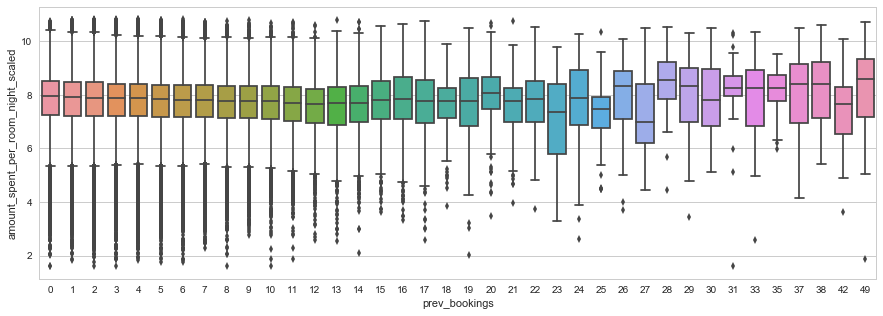

In [123]:
f,ax=plt.subplots(figsize=(15,5))
sns.boxplot(y='amount_spent_per_room_night_scaled',x='prev_bookings',data=train,ax=ax)

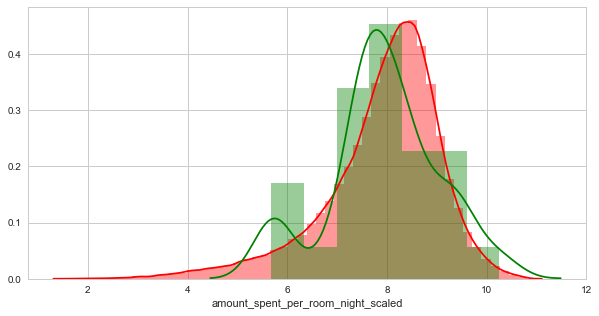

In [110]:
plt.figure(figsize=(10, 5))
sns.distplot(train[train['numberofadults'] >3 ]['amount_spent_per_room_night_scaled'][0:] , label = "1", color = 'red')
sns.distplot(train[train['numberofadults'] ==0 ]['amount_spent_per_room_night_scaled'][0:] , label = "1", color = 'green')
plt.show()

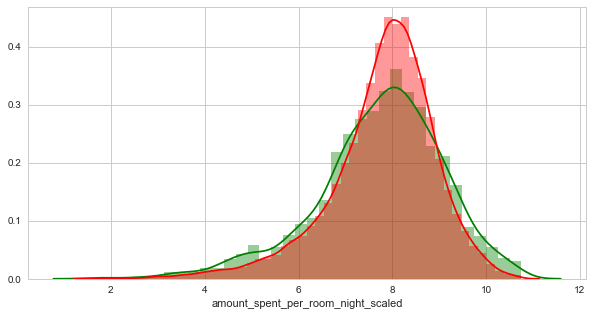

In [107]:
plt.figure(figsize=(10, 5))
sns.distplot(train[train['prev_bookings'] >15 ]['amount_spent_per_room_night_scaled'][0:] , label = "1", color = 'green')
sns.distplot(train[train['prev_bookings'] == 0]['amount_spent_per_room_night_scaled'][0:] , label = "0" , color = 'red' )
plt.show()

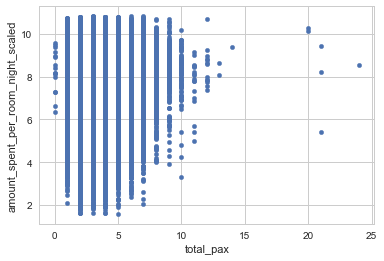

In [138]:

train.plot.scatter(x='total_pax',y='amount_spent_per_room_night_scaled')

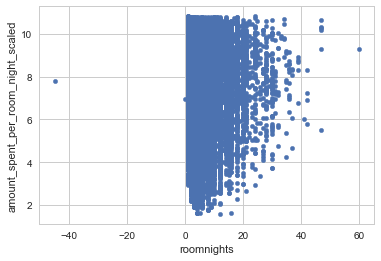

In [139]:

train.plot.scatter(x='roomnights',y='amount_spent_per_room_night_scaled')

In [12]:
temp=train[train['roomnights']<0]
temp

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,...,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,prev_bookings
36008,8cf7476b7111e0f969ef00d582f8a0833794239ebd3206...,30/12/14,22/03/15,29/03/15,1,2,4,3,45,1,...,6,4,D,1,a3af543aae775ab3cac3f789f74d5c0a70e6c0ecacb0db...,F,A,b17ef6d19c7a5b1ee83b907c595526dcb1eb06db8227d6...,7.779262,2


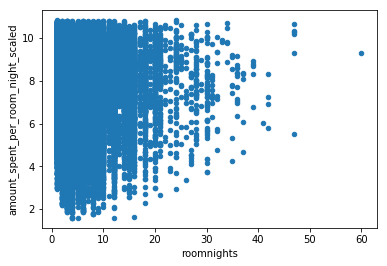

In [7]:
train=train[train['roomnights']>0]
train.plot.scatter(x='roomnights',y='amount_spent_per_room_night_scaled')

Most important Features :

[1] total_pax
[2] numberofadults
[3] prev_bookings
[4] channel code

# Insights on Data

(1) . There are few datapoints where total travellers = 0 ,those may be potential outliers.          
(2) . For some datapoints roomnight value is less then 0 ,these are potential outliers.
(3) . Season Holiday Code and State Code has some Null values , which has been replaced by Mode of each category.     
(4) . Number of adults have significant impact over the average spendings.
(5) . Frequent travellers who have previously booked 20 or more resorts tends to spend more.


# Data Preparation

In [124]:
train.columns

Index(['reservation_id', 'booking_date', 'checkin_date', 'checkout_date',
       'channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid',
       'cluster_code', 'reservationstatusid_code', 'resort_id',
       'amount_spent_per_room_night_scaled', 'prev_bookings'],
      dtype='object')

In [7]:
# Preparing Train Data
cat_cols=['channel_code','main_product_code','resort_region_code','resort_type_code','room_type_booked_code','state_code_residence'
         ,'state_code_resort','member_age_buckets','booking_type_code','reservationstatusid_code','cluster_code']
for c in cat_cols:
    lb=LabelEncoder()
    lb.fit(list(train[c].values))
    train[c]=lb.transform(list(train[c].values))
    

In [8]:
col_drop=['reservation_id','booking_date','checkin_date','checkout_date','amount_spent_per_room_night_scaled','memberid','resort_id']
y_train=train['amount_spent_per_room_night_scaled']
x_train=train.drop(col_drop,axis=1)

In [9]:
print(x_train.shape)
print(y_train.shape)

(341424, 18)
(341424,)


In [10]:
# Preparing Test Data
cat_cols=['channel_code','main_product_code','resort_region_code','resort_type_code','room_type_booked_code','state_code_residence'
         ,'state_code_resort','member_age_buckets','booking_type_code','reservationstatusid_code','cluster_code']
col_drop=['reservation_id','booking_date','checkin_date','checkout_date','memberid','resort_id']
for c in cat_cols:
    lb=LabelEncoder()
    lb.fit(list(test[c].values.astype(str)))
    test[c]=lb.transform(list(test[c].values.astype(str)))
x_test=test.drop(col_drop,axis=1)
mem_id=pd.Series(test['memberid'].tolist()).astype(str)
prev_bookings=[]
ctr=collections.Counter(mem_id)
for ele in mem_id:
    prev_bookings.append(ctr.get(ele))
prev_bookings=[(lambda x:x-1)(x)for x in prev_bookings]
x_test['prev_bookings']=prev_bookings
print(x_test.shape)

(146765, 18)


# Modelling


**Cross Validation:**

In [11]:
def cross_val(model):
    kf=KFold(n_splits=5,shuffle=True).get_n_splits(x_train)
    rmse=100*np.sqrt(-cross_val_score(model,x_train,y_train,scoring='neg_mean_squared_error',cv=kf,n_jobs=-1))
    return rmse

In [12]:
from sklearn.model_selection import RandomizedSearchCV
params={'n_estimators':[500,1000,2000,3000],'learning_rate':[0.008,0.01,0.05]}
def randomsearch_xgb():
    model=xgb.XGBRegressor()
    clf=RandomizedSearchCV(model,params,n_jobs=-1,scoring='neg_mean_squared_error')
    clf.fit(x_train,y_train)
    cv_data=pd.DataFrame(clf.cv_results_)
    return cv_data
    
    
    

In [13]:
# function to plot result of hyperparameter tunning using gridsearchCV
def plotResult(data):
    max_scores=data.groupby(['param_n_estimators','param_learning_rate']).max()
    max_scores=max_scores.unstack()[['mean_test_score','mean_train_score']]
    sns.heatmap((-1)*max_scores.mean_test_score,annot=True,fmt='.4g')

**Base Learners:**

Lasso Regressor :

In [14]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

Ridge Regressor :

In [15]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=4))

ElasticNet Regressor :

In [16]:
enet=make_pipeline(RobustScaler(),ElasticNet(alpha =0.0005, random_state=1))

GradientBoosting Regressor :

In [17]:
gbr=GradientBoostingRegressor(loss='huber',n_estimators=2000,min_samples_split=15,max_depth=4,learning_rate=0.05,verbose=1,n_iter_no_change=10)

Random Forest Regressor :

In [40]:
rf=RandomForestRegressor(n_estimators=500,min_samples_split=15,max_depth=3)

XGBoost Regressor :

In [63]:
# Cross validation using Randomized Search
cv_data=randomsearch_xgb()
plotResult(cv_data)

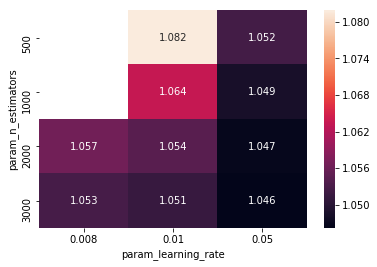

In [64]:
plotResult(cv_data)

In [42]:
xgbr = xgb.XGBRegressor(gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2300,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1,early_stopping_rounds=5)

LGBM Regressor :

In [36]:
lgbmr=lgb.LGBMRegressor(learning_rate=0.05, n_estimators=2500)


**Cross Validation on Base Models:**

In [289]:
scores=cross_val(lasso)
print('Lasso Regressor RMSE: {},Std. Dev:{} :'.format(scores.mean(),scores.std()))

Lasso Regressor RMSE: 105.2308618531521,Std. Dev:3.1966369970189144 :


In [303]:
scores=cross_val(enet)
print('Elastic Net Regressor RMSE: {},Std. Dev:{} :'.format(scores.mean(),scores.std()))

Elastic Net Regressor RMSE: 105.23153052752446,Std. Dev:3.197092097761539 :


In [307]:
scores=cross_val(ridge)
print('Ridge Regressor RMSE: {},Std. Dev:{} :'.format(scores.mean(),scores.std()))

Ridge Regressor RMSE: 105.2325921021613,Std. Dev:3.19762836947177 :


In [43]:
scores=cross_val(xgbr)
print('XGBoost Regressor RMSE: {},Std. Dev:{} :'.format(scores.mean(),scores.std()))

XGBoost Regressor RMSE: 102.1523836064072,Std. Dev:3.3100993435382753 :


In [37]:
scores=cross_val(lgbmr)
print('LightGBM Regressor RMSE: {},Std. Dev:{} :'.format(scores.mean(),scores.std()))

LightGBM Regressor RMSE: 102.28080355996799,Std. Dev:3.3419037267760623 :


In [41]:
scores=cross_val(rf)
print('RandomForest Regressor RMSE: {},Std. Dev:{} :'.format(scores.mean(),scores.std()))

RandomForest Regressor RMSE: 106.12806905714051,Std. Dev:3.1763496896764942 :


**Lasso Regressor Parameter Tunning:**

In [33]:
alpha=[0.0001,0.0005,0.0010,0.0050,0.01,0.05]
for i in alpha:
    lasso = make_pipeline(RobustScaler(), Lasso(alpha =i, random_state=1))
    k=KFold(n_splits=5,shuffle=True).get_n_splits(x_train)
    rmse=100*np.sqrt(-cross_val_score(lasso,x_train,y_train,scoring='neg_mean_squared_error',cv=kf,n_jobs=-1))
    print('RMSE : {} ,STDEV:{} for alpha:{}'.format(rmse.mean(),rmse.std(),i))

RMSE : 105.30895250928484 ,STDEV:3.2118322164787174 for alpha:0.0001
RMSE : 105.30718965868391 ,STDEV:3.209670680193875 for alpha:0.0005
RMSE : 105.30615323992029 ,STDEV:3.207164237936272 for alpha:0.001
RMSE : 105.35463442941452 ,STDEV:3.2148712222709572 for alpha:0.005
RMSE : 105.48433840340503 ,STDEV:3.229012095980094 for alpha:0.01
RMSE : 106.87056091547325 ,STDEV:3.0456453444087375 for alpha:0.05


In [34]:
# Final Lasso model
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.001, random_state=1))

**LGBM Parameter Tunning:**

In [31]:
# Tunning for n_estimators
n_est=[500,1000,1500,2000,2500,3000]
for n in n_est:
    lgbm=lgb.LGBMRegressor(learning_rate=0.05,min_child_samples=50, n_estimators=n,
                               bagging_fraction = 0.8)
    
    kf=KFold(n_splits=5,shuffle=True).get_n_splits(x_train)
    rmse=100*np.sqrt(-cross_val_score(lgbm,x_train,y_train,scoring='neg_mean_squared_error',cv=kf,n_jobs=-1))
    print('RMSE : {} ,STDEV:{} for n_estimators:{}'.format(rmse.mean(),rmse.std(),n))

RMSE : 101.97462743958856 ,STDEV:3.289770596151836 for n_estimators:500
RMSE : 101.97242847657398 ,STDEV:3.2830815846606525 for n_estimators:1000
RMSE : 102.03414542160642 ,STDEV:3.2826989649067375 for n_estimators:1500
RMSE : 102.11101688667422 ,STDEV:3.2811158124113766 for n_estimators:2000
RMSE : 102.21101322157048 ,STDEV:3.2818842998857907 for n_estimators:2500
RMSE : 102.30979451896818 ,STDEV:3.2836379559121074 for n_estimators:3000


In [24]:
# Tunning for min samples
min_samples=[10,20,30,40,50,100,200]
for n in min_samples:
    lgbm=lgb.LGBMRegressor(learning_rate=0.05,min_child_samples=n, n_estimators=1500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9)
    
    kf=KFold(n_splits=5,shuffle=True).get_n_splits(x_train)
    rmse=100*np.sqrt(-cross_val_score(lgbm,x_train,y_train,scoring='neg_mean_squared_error',cv=kf,n_jobs=-1))
    print('RMSE : {} ,STDEV:{} for min_child_samples:{}'.format(rmse.mean(),rmse.std(),n))

RMSE : 101.99755386051957 ,STDEV:3.29049847078544 for min_child_samples:10
RMSE : 101.9902614134147 ,STDEV:3.2704994504123834 for min_child_samples:20
RMSE : 101.96750913241871 ,STDEV:3.2683396894054764 for min_child_samples:30
RMSE : 101.96533900438682 ,STDEV:3.275115624032651 for min_child_samples:40
RMSE : 101.95200513764452 ,STDEV:3.2742136179060983 for min_child_samples:50
RMSE : 101.90582913109054 ,STDEV:3.277340903924942 for min_child_samples:100
RMSE : 101.88989607374086 ,STDEV:3.2771760584202116 for min_child_samples:200


In [25]:
#Tunning for Learning rate
learning_rate=[0.005,0.01,0.03,0.05]
for n in learning_rate:
    lgbm=lgb.LGBMRegressor(learning_rate=n,min_child_samples=100, n_estimators=1500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9)
    
    kf=KFold(n_splits=5,shuffle=True).get_n_splits(x_train)
    rmse=100*np.sqrt(-cross_val_score(lgbm,x_train,y_train,scoring='neg_mean_squared_error',cv=kf,n_jobs=-1))
    print('RMSE : {} ,STDEV:{} for Learnig Rate:{}'.format(rmse.mean(),rmse.std(),n))

RMSE : 102.68764757856736 ,STDEV:3.3143416904491922 for Learnig Rate:0.005
RMSE : 102.21326274147961 ,STDEV:3.317908208062817 for Learnig Rate:0.01
RMSE : 101.89917435694568 ,STDEV:3.2924962605617405 for Learnig Rate:0.03
RMSE : 101.90582913109054 ,STDEV:3.277340903924942 for Learnig Rate:0.05


In [39]:
# Final Tuned LightGBM Model
lgbm=lgb.LGBMRegressor(learning_rate=0.03,min_child_samples=100, n_estimators=1500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9)

**Stacked Regressor:**

In [74]:
#https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [76]:
stacked_averaged_models = StackingAveragedModels(base_models = (enet, xgbr, rf),
                                                 meta_model = lgbm)
score = cross_val(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 102.1315 (3.3068)


# Predictions :

In [ ]:
stacked_averaged_models.fit(x_train,y_train)
lgbmr.fit(x_train,y_train)
xgbr.fit(x_train,y_train)
y_pred_lgbm=lgbmr.predict(x_test)
y_pred_xgb=xgbr.predict(x_test)
y_pred_strgr=stacked_averaged_models.predict(x_test)
y_pred_final=y_pred_lgbm*0.15+y_pred_xgb*0.15+y_pred_strgr*0.80

# Submission:

In [29]:

sub=pd.DataFrame()
sub['reservation_id']=test['reservation_id']
sub['amount_spent_per_room_night_scaled']=y_pred_final

In [78]:
sub.to_csv('Submission.csv',index=False)

# Observations :

[1]. For the above problem we have used stacked Regressor , The Base liners used for the stack regressor are lasso ,XGBDT and Random Forest . LightGBM is used as Meta Classifier.                                                               
[2] We took a weighted average of stacked classifier ,LightGBM and XGBDT for final prediction.                 
[3] Though in Competetive set ups Stacked Classifier gives better accuracy but in practice a single fine tuned ensamble will be more prefarable because of it low latency and complexity .